In [16]:
! pip install --user annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552403 sha256=3f27ec9f869b3852931845a9e46ec404fe07e97768c19308ba09343de409e927
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


**Load data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/reverse image search/wikiart_scraped.csv')

In [53]:
train_dataset = dataset[:100]
test_dataset = dataset[100:105]

In [31]:
train_dataset.columns

Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')

In [32]:
from PIL import Image
import requests

def load_image(url):
  return Image.open(requests.get(url, stream=True).raw)

**Load resnet-18**

source: https://towardsdatascience.com/recommending-similar-images-using-pytorch-da019282770c

In [33]:
import numpy as np

In [34]:
import torch
from torchvision import transforms
import torchvision
torch.manual_seed(17)

class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def getFeatureLayer(self):
      cnnModel = torchvision.models.resnet18(pretrained=True)
      layer = cnnModel._modules.get('avgpool')
      self.layer_output_size = 512

      return cnnModel, layer

    def getVec(self, img):
      image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
      embedding = torch.zeros(1, self.numberFeatures, 1, 1)
      def copyData(m, i, o): embedding.copy_(o.data)
      h = self.featureLayer.register_forward_hook(copyData)
      self.model(image)
      h.remove()
      return embedding.numpy()[0, :, 0, 0]

** *italicised text*Embed first 100 images**

In [8]:
import tqdm
import os

img2vec = Img2VecResnet18()
allVectors = {}

for index, row in train_dataset.iterrows():
    url = row['Link']
    image = load_image(url)
    vec = img2vec.getVec(image)
    allVectors[index] = vec

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 24.9MB/s]


In [9]:
len(allVectors)

100

**Save embeddings**

In [3]:
import os
os.chdir('/content/drive/MyDrive/reverse image search/')

In [4]:
# Convert the dictionary values into a list of matrices
embedding_matrices = list(allVectors.values())
# Convert the list of matrices into a single NumPy array
all_embeddings = np.array(embedding_matrices)
# Save all embeddings as a single .npy file
np.save('all_embeddings.npy', all_embeddings)

NameError: ignored

Load the saved embeddings from drive

In [6]:
import numpy as np

# Load all embeddings from the .npy file
all_embeddings = np.load('all_embeddings.npy')
all_embeddings.shape

(100, 512)

In [ ]:
# # Initialize an empty dictionary to store the loaded embeddings
# loaded_embeddings_dict = {}

# # Assuming your keys are image indices
# for index, embedding_matrix in enumerate(all_embeddings):
#     # Store each embedding matrix in the loaded_embeddings_dict
#     loaded_embeddings_dict[index + 1] = embedding_matrix

# # Now you have the embeddings loaded back into the dictionary
# print(loaded_embeddings_dict)

In [8]:
# !pip install annoy

In [9]:
import annoy

In [28]:
from annoy import AnnoyIndex
import random

# Number of dimensions in the embeddings
embedding_dim = all_embeddings.shape[1]

# Build Annoy index
annoy_index = AnnoyIndex(embedding_dim, metric='angular')  # 'angular' metric for cosine similarity

# Add items (vectors) to the index
for i, embedding in enumerate(all_embeddings):
    annoy_index.add_item(i, embedding)

# Build the index with a specified number of trees
num_trees = 50  # Adjust this value based on your requirements
annoy_index.build(num_trees)
# ...



True

In [29]:
print(annoy_index)

In [54]:
test_dataset

,Style,Artwork,Artist,Date,Link
100,New-Kingdom,Tomb of Nakht,Ancient Egypt,1390 BC,https://uploads7.wikiart.org/00244/images/anci...
101,New-Kingdom,Fragment of a Doorjamb from the Tomb of Djehut...,Ancient Egypt,1450-1390 BC,https://uploads2.wikiart.org/00244/images/anci...
102,New-Kingdom,South Wall of Nakht's Offering Chapel,Ancient Egypt,1410-1370 BC,https://uploads6.wikiart.org/00244/images/anci...
103,New-Kingdom,Bench Side Panel Depicting a Calf in the Marshes,Ancient Egypt,1390-1353 BC,https://uploads7.wikiart.org/00244/images/anci...
104,New-Kingdom,Ceiling Painting from the Palace of Amenhotep III,Ancient Egypt,1390-1353 BC,https://uploads8.wikiart.org/00244/images/anci...


In [62]:
# Load the embedding of the other image you want to compare

test_image_url = test_dataset.iloc[4]['Link']
test_image = load_image(test_image_url)

img2vec = Img2VecResnet18()
test_image_vec = img2vec.getVec(test_image)
print(test_image_vec)

[0.75757295 0.56173104 0.62970924 1.6679813  0.4045013  0.5031723
 1.2035395  1.063395   1.1301033  0.8336852  0.47696552 0.57295793
 0.19926879 0.6601169  0.24017859 1.9443712  0.14265186 0.92495805
 0.39569458 1.201063   0.37364826 0.37010095 0.42427558 0.37281287
 0.56909055 1.0887233  0.3124017  2.180657   0.7973319  0.24521571
 0.64685214 0.33347175 0.51437813 0.80726874 0.23600264 0.9658369
 0.14712913 1.5924059  1.0258609  0.7061393  0.13622548 1.8142143
 0.51255745 1.1874028  0.59663934 0.33222243 0.5582062  0.39509428
 0.25036818 0.6581398  0.43949863 0.507181   0.24433324 1.109108
 0.41668698 0.77641726 0.8959895  0.34597233 1.7755474  0.1746704
 0.18419823 0.6977583  0.98230064 1.1019713  0.6568508  0.71562797
 0.42504638 0.306573   0.27562615 0.86550295 0.29102764 1.192646
 0.29454947 1.4291924  0.452145   1.4625859  0.6229538  0.241525
 0.26824716 0.567101   0.89127624 0.13302855 0.7870188  0.7540239
 0.29997855 0.6304724  0.44214416 0.486107   0.5095667  0.41081417
 0.443

In [63]:
# Get the index of the nearest neighbor (most similar) to the other image's embedding
nearest_neighbor_index = annoy_index.get_nns_by_vector(test_image_vec, 1, search_k=-1)[0]

# Print the index of the nearest neighbor
print("Nearest neighbor index:", nearest_neighbor_index)


Nearest neighbor index: 61


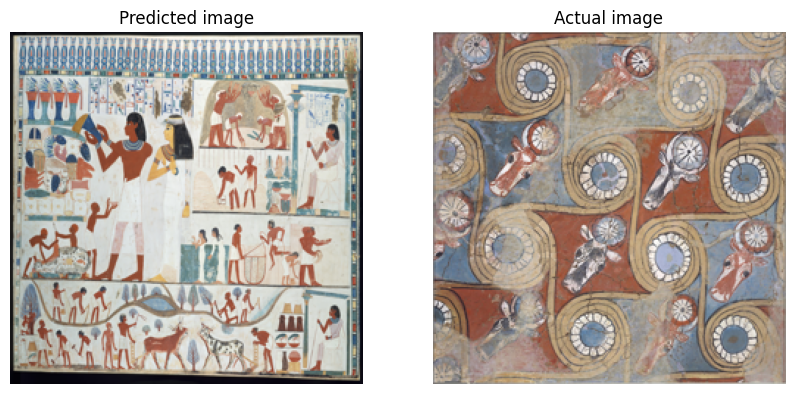

In [64]:
import matplotlib.pyplot as plt

verify_test_image_url = train_dataset.iloc[nearest_neighbor_index]['Link']
verify_test_image = load_image(verify_test_image_url)

verify_test_image = verify_test_image.resize((240,240))
test_image = test_image.resize((240,240))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Display the first image on the left subplot
axes[0].imshow(verify_test_image)
axes[0].axis('off')  # Turn off axis labels and ticks
axes[0].set_title('Predicted image')  # Set a title if desired

# Display the second image on the right subplot
axes[1].imshow(test_image)
axes[1].axis('off')  # Turn off axis labels and ticks
axes[1].set_title('Actual image')  # Set a title if desired

# Show the plots
plt.show()